In [ ]:
import numpy as np
import requests
import gzip
import os

def download_fashion_mnist(url, file_name):
    # Check if file already exists
    if not os.path.exists(file_name):
        # Download the file
        r = requests.get(url)
        with open(file_name, 'wb') as f:
            f.write(r.content)

def load_fashion_mnist(image_file, label_file):
    # Read image file
    with gzip.open(image_file, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    # Read label file
    with gzip.open(label_file, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return images, labels

# URLs for Fashion MNIST dataset
image_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
label_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'

# File names to save the downloaded files
image_file = 'train-images-idx3-ubyte.gz'
label_file = 'train-labels-idx1-ubyte.gz'

# Download Fashion MNIST dataset
download_fashion_mnist(image_url, image_file)
download_fashion_mnist(label_url, label_file)

# Load Fashion MNIST dataset
train_images, train_labels = load_fashion_mnist(image_file, label_file)

# URLs for Fashion MNIST test dataset
test_image_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
test_label_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'

# File names to save the downloaded files for test dataset
test_image_file = 't10k-images-idx3-ubyte.gz'
test_label_file = 't10k-labels-idx1-ubyte.gz'

# Download Fashion MNIST dataset
download_fashion_mnist(test_image_url, test_image_file)
download_fashion_mnist(test_label_url, test_label_file)

# Load Fashion MNIST dataset
test_images, test_labels = load_fashion_mnist(test_image_file, test_label_file)

# Class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [3]:
def compute_accuracy(pairs, num_classes):
    """
    Compute the overall accuracy.
    
    Parameters:
        pairs: List or array of (true_label, pred_label) pairs.
        num_classes: Total number of classes (this parameter is kept for interface consistency).
        
    Returns:
        overall_accuracy: A float representing the proportion of correct predictions (range: 0 to 1).
    """
    total = len(pairs)
    if (total == 0):
        return 0.0
    correct = 0
    for (true_label, pred_label) in pairs:
        if (true_label == pred_label):
            correct += 1
    overall_accuracy = correct / total
    return overall_accuracy

def compute_per_class_accuracy(pairs, num_classes):
    """
    Compute per-class accuracy using dictionaries.

    Parameters:
        pairs: A list of (true_label, pred_label) pairs.
        num_classes: The total number of classes.
        
    Returns:
        A list of accuracies for each class (index i corresponds to class i).
        Accuracy for a class is defined as the number of correct predictions for that class
        divided by the total number of occurrences of that class in the true labels.
    """
    # Initialize dictionaries to hold counts for each class.
    correct_count = {}
    total_count = {}
    
    # Iterate over all (true_label, pred_label) pairs.
    for (true_label, pred_label) in pairs:
        # Update the total count for the true label.
        if (true_label in total_count):
            total_count[true_label] += 1
        else:
            total_count[true_label] = 1

        # If the prediction is correct, update the correct count for the true label.
        if (true_label == pred_label):
            if (true_label in correct_count):
                correct_count[true_label] += 1
            else:
                correct_count[true_label] = 1
    
    # Create a list to store the accuracy for each class in order from 0 to num_classes-1.
    per_class_accuracy = []
    for i in range(num_classes):
        # If a class does not appear in the total count, set its accuracy to 0.0.
        if ((i not in total_count.keys()) or (total_count.get(i) == 0)):
            per_class_accuracy.append(0.0)
        else:
            # Get the number of correct predictions for category i from the dictionary correct_count. 
            # If there is no record for category i in the dictionary, return the default value 0.
            per_class_accuracy.append(correct_count.get(i, 0) / total_count[i])
    
    return per_class_accuracy

def compute_confusion_matrix(pairs, num_classes):
    """
    Compute the confusion matrix.
    
    Parameters:
        pairs: List or array of (true_label, pred_label) pairs.
        num_classes: Total number of classes.
        
    Returns:
        A 2D numpy array of shape (num_classes, num_classes), where element [i, j]
        indicates the number of samples with true label i that were predicted as j.
    """
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for (true_label, pred_label) in pairs:
        confusion_matrix[true_label, pred_label] += 1
    return confusion_matrix

### Data Visualization and Statistics

In [4]:
def visualize_fashion_mnist(images, labels, class_names, num_images=16):
    """
    Visualize a set of random images from the dataset.

    Parameters:
        images: numpy array of images, expected shape (num_samples, 28, 28)
        labels: numpy array of labels corresponding to the images
        class_names: list of class names corresponding to label indices
        num_images: number of random images to display (default is 16)
    """
    # Randomly choose 'num_images' indices from the datase.
    # No duplicates are allowed (sampling without replacement).
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Set up the plot: here we use a square grid for visualization.
    grid_size = int(np.ceil(np.sqrt(num_images)))
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    
    for i, idx in enumerate(indices):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def compute_class_counts(labels, num_classes):
    """
    Compute the number of samples for each class.

    Parameters:
        labels: numpy array of labels
        num_classes: total number of classes

    Returns:
        A numpy array of length 'num_classes' where each element is the count
        of samples belonging to that class.
    """
    counts = np.zeros(num_classes, dtype=int)
    for label in labels:
        counts[label] += 1
    return counts

### Data Preprocessing

In [5]:
def preprocess_data(train_images, test_images):
    """
    Preprocess the Fashion MNIST images by flattening and standardizing them.
    
    This function first reshapes each image from 28x28 to a 784-dimensional vector.
    It then computes the per-pixel mean and standard deviation on the training set
    and uses these statistics to normalize both the training and test sets.
    
    Parameters:
        train_images: numpy array of shape (num_train, 28, 28)
        test_images:  numpy array of shape (num_test, 28, 28)
    
    Returns:
        train_processed:
            numpy array of shape (num_train, 784)
            Flattened and normalized training images.
        test_processed:
            numpy array of shape (num_test, 784)
            Flattened and normalized test images.
        mean:
            numpy array of shape (784,)
            Per-pixel mean computed from the training set.
        std:
            numpy array of shape (784,)
            Per-pixel standard deviation computed from the training set.
    """
    # Flatten the training and test images from (num_samples, 28, 28) to (num_samples, 784)
    train_flat = train_images.reshape(train_images.shape[0], -1)
    test_flat = test_images.reshape(test_images.shape[0], -1)
    
    # Compute the per-pixel mean and standard deviation from the training set
    mean = np.mean(train_flat, axis=0)
    std = np.std(train_flat, axis=0)
    
    # To avoid division by zero in case any std is 0, replace 0s with 1
    # std[std == 0] = 1
    # Ensure no std is zero to avoid division by zero
    std = np.where(std == 0, 1, std)
    
    # Normalize both training and test images using the training set statistics
    train_processed = (train_flat - mean) / std
    test_processed = (test_flat - mean) / std
    
    return train_processed, test_processed, mean, std

### K-NN Classifier

In [6]:
def knn_classifier(train_data, train_labels, test_data, test_labels, k_values=[5], weight_options=['uniform']):
    """
    Train and evaluate a k-NN classifier with hyperparameter tuning.
    
    Splits the provided training data into a tuning training subset (approximately 59,000 examples)
    and a validation set (1,000 examples) for hyperparameter tuning.
    Iterates over combinations of k values and weight options to train a k-NN classifier on the tuning
    training subset and evaluate it on the validation set. It outputs the overall accuracy for each combination.
    Selects the best hyperparameters based on the highest validation accuracy.
    Retrains a new k-NN classifier on the full training set (all examples) using the best parameters.
    Evaluates the final model on the test set and outputs the best validation accuracy, test accuracy and per class accuracy.
    
    Parameters:
        train_data:
            numpy array of shape (num_train_samples, num_features)
            Preprocessed training data.
        train_labels:
            array-like of shape (num_train_samples,)
            Labels corresponding to the training data.
        test_data:
            numpy array of shape (num_test_samples, num_features)
            Preprocessed test data.
        test_labels:
            array-like of shape (num_test_samples,)
            Labels corresponding to the test data.
        k_values:
            list of integers (default: [5])
            List of different k (number of neighbors) values to try.
        weight_options:
            list of strings (default: ['uniform'])
            List of weight options to try such as ['uniform', 'distance'].
                        
    Returns:
        final_model: The k-NN classifier retrained on the full training set using the best hyperparameters.
        best_params: A tuple (best_k, best_weight) representing the hyperparameters that achieved the highest validation accuracy.
        best_val_accuracy: The best validation accuracy achieved during tuning.
        test_accuracy: The overall accuracy of the final model on the test set.
        cm_test: The confusion matrix (numpy array) computed on the test set.
    """
    # Set a random seed for reproducibility.
    np.random.seed(42)
    num_samples = train_data.shape[0]
    
    # Check if there are enough samples to split.
    if (num_samples < 1000):
        raise ValueError("Not enough samples in training data to form a validation set.")
    
    # Shuffle indices and split into a validation set (1,000 samples) and tuning training subset (remaining samples).
    indices = np.random.permutation(num_samples)
    val_indices = indices[:1000] # 1,000 examples for validation.
    tune_train_indices = indices[1000:] # Remaining examples (≈59,000) for tuning.
    
    tune_train_data = train_data[tune_train_indices]
    tune_train_labels = train_labels[tune_train_indices]
    val_data = train_data[val_indices]
    val_labels = train_labels[val_indices]
    
    best_val_accuracy = 0.0
    best_params = None
    best_model_tuned = None
    num_classes = len(np.unique(train_labels))
    
    # Hyperparameter tuning over the grid of k values and weight options.
    for k in k_values:
        for weight in weight_options:
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
            knn.fit(tune_train_data, tune_train_labels)
            
            # Evaluate on the validation set.
            predictions_val = knn.predict(val_data)
            # Create (true_label, predicted_label) pairs.
            pairs_val = list(zip(val_labels, predictions_val))
            acc_val = compute_accuracy(pairs_val, num_classes)
            print(f"Parameters: k = {k}, weights = '{weight}' -> Validation Accuracy: {acc_val:.4f}")
            
            # Update best model if this configuration has higher validation accuracy.
            if (acc_val > best_val_accuracy):
                best_val_accuracy = acc_val
                best_params = (k, weight)
                best_model_tuned = knn
    
    print(f"\nBest hyperparameters: k = {best_params[0]}, weights = '{best_params[1]}' with validation accuracy: {best_val_accuracy:.4f}")
    
    # Retrain a new k-NN classifier on the entire training set using the best hyperparameters.
    final_model = KNeighborsClassifier(n_neighbors=best_params[0], weights=best_params[1])
    final_model.fit(train_data, train_labels)
    
    # Evaluate the final model on the test set.
    test_predictions = final_model.predict(test_data)
    pairs_test = list(zip(test_labels, test_predictions))
    test_accuracy = compute_accuracy(pairs_test, num_classes)
    cm_test = compute_confusion_matrix(pairs_test, num_classes)
    per_class_test_accuracy = compute_per_class_accuracy(pairs_test, num_classes)
    
    print(f"Final Validation Accuracy (from tuning): {best_val_accuracy:.4f}")
    print(f"Test Accuracy on the Test Set: {test_accuracy:.4f}\n")
    print("Confusion Matrix on Test Set:")
    for i in range(num_classes):
        print(f"Class {i}: {cm_test[i]}")
    print("\nPer Class Accuracy on Test Set:")
    for i, acc in enumerate(per_class_test_accuracy):
        print(f"Class {i}: {acc:.4f}")
    
    return final_model, best_params, best_val_accuracy, test_accuracy, cm_test

### K-NN with PCA Classifier

In [7]:
def knn_classifier_pca(train_data, train_labels, test_data, test_labels, k_values=[5], weight_options=['uniform'], m_values=[50]):
    """
    Train and evaluate a k-NN classifier with hyperparameter tuning that includes PCA.
    
    Splits the provided training data into a tuning subset (≈59,000 samples) and a validation set (1,000 samples).
    For each combination of PCA components (m), k (number of neighbors), and weight options,
    it fits PCA on the tuning training subset, transforms both the tuning data and validation data,
    trains a k-NN classifier on the PCA-transformed tuning data, and evaluates on the PCA-transformed validation set.
    
    Selects the best hyperparameters (m, k, and weight) based on the highest validation accuracy.
    Retrains a new k-NN classifier on the entire training set (60,000 samples) using the best hyperparameters.
    The training set is first transformed using PCA (with best m), and the same transformation is applied to the test set.
    Evaluates the final model on the test set, outputting the best validation accuracy, test accuracy and per class accuracy,
    as well as the test set's confusion matrix.
    
    Parameters:
        train_data:
            numpy array of shape (num_train_samples, num_features)
            The preprocessed training data.
        train_labels:
            array-like of shape (num_train_samples,)
            Labels corresponding to the training data.
        test_data:
            numpy array of shape (num_test_samples, num_features)
            The preprocessed test data.
        test_labels:
            array-like of shape (num_test_samples,)
            Labels corresponding to the test data.
        k_values:
            list of integers (default: [5])
            Different k values to try for the k-NN classifier.
        weight_options:
            list of strings (default: ['uniform'])
            Different weight options to try (e.g., ['uniform', 'distance']).
        m_values:
            list of integers (default: [50])
            Different numbers of PCA components to try.
    
    Returns:
        final_model: The k-NN classifier retrained on the full training set using the best hyperparameters.
        best_params: A tuple (best_k, best_weight, best_m) representing the best hyperparameters.
        best_val_accuracy: The highest validation accuracy achieved during tuning.
        test_accuracy: The overall accuracy of the final model on the test set.
        cm_test: The confusion matrix (numpy array) computed on the test set.
    """
    # Set a random seed for reproducibility.
    np.random.seed(42)
    num_samples = train_data.shape[0]
    
    if (num_samples < 1000):
        raise ValueError("Not enough samples in training data to form a validation set.")
    
    # Shuffle indices and split into a validation set (1,000 samples) and tuning training subset (remaining samples).
    indices = np.random.permutation(num_samples)
    val_indices = indices[:1000] # 1,000 samples for validation.
    tune_train_indices = indices[1000:] # Remaining samples (~59,000) for tuning.
    
    tune_train_data = train_data[tune_train_indices]
    tune_train_labels = train_labels[tune_train_indices]
    val_data = train_data[val_indices]
    val_labels = train_labels[val_indices]
    
    best_val_accuracy = 0.0
    best_params = None # will hold (best_k, best_weight, best_m)
    num_classes = len(np.unique(train_labels))
    
    # Hyperparameter tuning: iterate over each combination of m, k, and weight.
    for m in m_values:
        # Fit PCA on the tuning training subset.
        pca = PCA(n_components=m)
        pca.fit(tune_train_data)
        # Transform both tuning training data and validation data.
        tune_train_data_pca = pca.transform(tune_train_data)
        val_data_pca = pca.transform(val_data)
        
        for k in k_values:
            for weight in weight_options:
                # Train a k-NN classifier on the PCA-transformed tuning data.
                knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
                knn.fit(tune_train_data_pca, tune_train_labels)
                
                # Predict on the PCA-transformed validation data.
                predictions_val = knn.predict(val_data_pca)
                pairs_val = list(zip(val_labels, predictions_val))
                acc_val = compute_accuracy(pairs_val, num_classes)
                print(f"Parameters: m = {m}, k = {k}, weights = '{weight}' -> Validation Accuracy: {acc_val:.4f}")
                
                # Update best parameters if this configuration has higher validation accuracy.
                if (acc_val > best_val_accuracy):
                    best_val_accuracy = acc_val
                    best_params = (k, weight, m)
    
    print(f"\nBest hyperparameters: k = {best_params[0]}, weights = '{best_params[1]}', m = {best_params[2]} with validation accuracy: {best_val_accuracy:.4f}")
    
    # Retrain final model on the full training set using the best hyperparameters.
    best_k, best_weight, best_m = best_params
    final_pca = PCA(n_components=best_m)
    final_pca.fit(train_data)
    
    # Transform the full training set and test set using the final PCA model.
    train_data_pca = final_pca.transform(train_data)
    test_data_pca = final_pca.transform(test_data)
    
    final_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
    final_model.fit(train_data_pca, train_labels)
    
    # Evaluate on the test set.
    test_predictions = final_model.predict(test_data_pca)
    pairs_test = list(zip(test_labels, test_predictions))
    test_accuracy = compute_accuracy(pairs_test, num_classes)
    cm_test = compute_confusion_matrix(pairs_test, num_classes)
    per_class_test_accuracy = compute_per_class_accuracy(pairs_test, num_classes)
    
    print(f"Final Validation Accuracy (from tuning): {best_val_accuracy:.4f}")
    print(f"Test Accuracy on the Test Set: {test_accuracy:.4f}\n")
    print("Confusion Matrix on Test Set:")
    for i in range(num_classes):
        print(f"Class {i}: {cm_test[i]}")
    print("\nPer Class Accuracy on Test Set:")
    for i, acc in enumerate(per_class_test_accuracy):
        print(f"Class {i}: {acc:.4f}")
    
    return final_model, best_params, best_val_accuracy, test_accuracy, cm_test

### Test accuracy performance functions

In [8]:
'''
Test code for error metrics. Leave this unchanged.
'''
test_pairs = [
    (1, 1),
    (1, 4),
    (0, 0),
    (0, 2),
    (3, 1),
    (4, 2),
    (4, 4),
    (2, 2),
    (2, 2),
    (3, 3),
    (4, 0),
    (4, 4),
    (1, 1),
    (0, 0),
    (0, 2),
    (1, 4),
    (1, 1),
    (0, 0),
    (0, 1),
    (2, 3),
]

num_classes = 5
accuracy = compute_accuracy(test_pairs, num_classes)
print(f'accuracy: {accuracy:.2f}')

per_class_accuracy = compute_per_class_accuracy(test_pairs, num_classes)
print()
print('Per class accuracy')
for i, acc in enumerate(per_class_accuracy):
    print(f'{i}: {acc:4.2f}')

cm = compute_confusion_matrix(test_pairs, num_classes)
print(f'\nConfusion matrix')
for i in range(num_classes):
    print(f'{i:2d}:', end='')
    for j in range(num_classes):
        print(f' {cm[i, j]:2d}', end='')
    print()

accuracy: 0.55

Per class accuracy
0: 0.50
1: 0.60
2: 0.67
3: 0.50
4: 0.50

Confusion matrix
 0:  3  1  2  0  0
 1:  0  3  0  0  2
 2:  0  0  2  1  0
 3:  0  1  0  1  0
 4:  1  0  1  0  2


### Main section: using KNN classifier to classify the data set and get the final accuracy

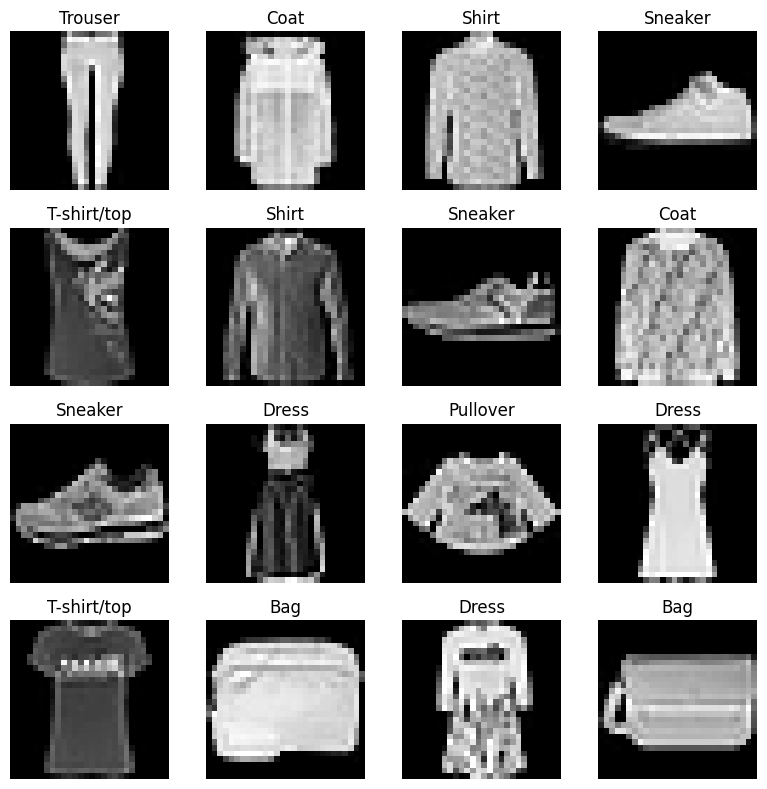

Training Set Class Counts:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000

Test Set Class Counts:
T-shirt/top: 1000
Trouser: 1000
Pullover: 1000
Dress: 1000
Coat: 1000
Sandal: 1000
Shirt: 1000
Sneaker: 1000
Bag: 1000
Ankle boot: 1000

Preprocessing complete:
Train processed shape: (60000, 784)
Test processed shape: (10000, 784)

=== Running k-NN Classifier without PCA ===
Parameters: k = 3, weights = 'uniform' -> Validation Accuracy: 0.8650
Parameters: k = 3, weights = 'distance' -> Validation Accuracy: 0.8670
Parameters: k = 5, weights = 'uniform' -> Validation Accuracy: 0.8680
Parameters: k = 5, weights = 'distance' -> Validation Accuracy: 0.8700
Parameters: k = 7, weights = 'uniform' -> Validation Accuracy: 0.8670
Parameters: k = 7, weights = 'distance' -> Validation Accuracy: 0.8700
Parameters: k = 9, weights = 'uniform' -> Validation Accuracy: 0.8700
Parameters: k = 9, weights = 'distance' -> 

In [9]:
# Data Visualization
# Visualize a random sample (e.g., 16 images) from the training set.
visualize_fashion_mnist(train_images, train_labels, class_names, num_images=16)

# Compute and Print Class Counts
num_classes = len(class_names)
train_counts = compute_class_counts(train_labels, num_classes)
test_counts = compute_class_counts(test_labels, num_classes)

print("Training Set Class Counts:")
for i, count in enumerate(train_counts):
    print(f"{class_names[i]}: {count}")

print("\nTest Set Class Counts:")
for i, count in enumerate(test_counts):
    print(f"{class_names[i]}: {count}")

# Data Preprocessing
# Preprocess the images: flatten (28x28 -> 784) and normalize (zero mean, unit variance).
train_processed, test_processed, mean, std = preprocess_data(train_images, test_images)
print("\nPreprocessing complete:")
print("Train processed shape:", train_processed.shape)
print(f"Test processed shape: {test_processed.shape}\n")

# k-NN Classifier without PCA
print("=== Running k-NN Classifier without PCA ===")
# Here, the knn_classifier function will internally split the training data into
# 59,000 for tuning and 1,000 for validation, tune hyperparameters (k and weights),
# retrain on the full training set, and evaluate on the test set.
final_knn_model, best_params, best_val_acc, test_acc, test_cm = knn_classifier(
    train_processed, train_labels, test_processed, test_labels,
    k_values=[3, 5, 7, 9, 11], weight_options=['uniform', 'distance']
)
# k-NN Classifier with PCA (Extra Credit ^o^, please)
print("\n=== Running k-NN Classifier with PCA ===")
# Here, the knn_classifier_pca function (renamed from your provided version) performs the same process as knn_classifier,
# but includes PCA in the pipeline. It tunes the number of principal components (m) along with k and weight options.
final_knn_pca_model, best_params_pca, best_val_acc_pca, test_acc_pca, test_cm_pca = knn_classifier_pca(
    train_processed, train_labels, test_processed, test_labels,
    k_values=[3, 5, 7, 9, 11], weight_options=['uniform', 'distance'], m_values=[50, 100, 150]
)

### Analysis

Overall, the experiments demonstrate that even a simple k-NN classifier can perform impressively on the balanced Fashion MNIST dataset. Without PCA, the model achieved a test accuracy of about 85.1%, while incorporating PCA slightly improved performance to around 86.0%. The easiest classes to recognize were Trouser and Ankle boot, each exceeding 95% accuracy, whereas Shirt proved to be the most challenging, with an accuracy near 61–62%. The confusion matrix revealed that T-shirt/top and Shirt are often mistaken for one another, and there is also notable confusion between visually similar classes such as Pullover and Coat. These findings underscore the importance of hyperparameter tuning—specifically, the choice of k and the weighting scheme, with optimal settings being k=9 with distance-based weighting for the non-PCA model and k=7 (with 100 PCA components) for the PCA-enhanced model. 